## Data

In [43]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

In [116]:
#First look
head(train.data)
#Maximum and Minimum value of output variable
max <- which.max(train.data$VALENCE.PLEASANTNESS)
min <- which.min(train.data$VALENCE.PLEASANTNESS)
train.data$VALENCE.PLEASANTNESS[min]
train.data$VALENCE.PLEASANTNESS[max]

,Intensity,VALENCE.PLEASANTNESS,SWEETORSOUR,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
,<fct>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,low,45,FALSE,302.0,208.33,5.952,19.698,34.491,21.523,39.571,...,0,0,1,0,1,0,1,0,1,0
2,high,49,TRUE,72.6,122.18,6.431,11.349,18.745,12.261,21.285,...,0,0,0,0,0,0,0,0,0,0
3,high,56,TRUE,259.0,242.29,7.572,20.832,32.167,21.693,35.535,...,0,0,1,0,1,1,1,0,1,1
4,high,7,FALSE,56.6,88.12,6.294,7.537,14.189,7.955,16.080,...,0,0,0,0,0,0,0,0,0,0
5,low,51,FALSE,84.7,136.21,6.191,12.876,21.629,14.023,24.701,...,0,0,0,0,0,0,0,0,0,0
6,high,21,FALSE,160.0,192.28,6.409,17.644,29.723,19.000,33.740,...,0,0,0,0,1,0,1,0,1,0


[1] 0

[1] 98

**Output variable (dependent variable): VALENCE.PLEASANTNESS**
- min. value (in the training set) = 0
- max. value (in the training set) = 98

**Input variables (predictors):**
- 4870 different predictors
- Intensity is a categorical variable with the levels low and high

**SWEETORSOUR:**
- output variable for the second task
- not included in the test set
- not usable for the regression task

## Variance

In [143]:
#convert the variable intensity into 2=low and 1=high (so that we can apply variance and correlation)
numeric.intensity <- as.numeric(train.data$Intensity)


In [148]:
#searching for input variables with zero variance (without the varible Intensity)
y <- train.data$VALENCE.PLEASANTNESS
x <- train.data[, -c(2,3)]
x$Intensity <- numeric.intensity
idx.zero.var <- apply(x, 2, var) == 0 
x <- x[,!idx.zero.var]


Thereby we could reduce the number of predictors from 4871 to 3028

## First linear Regression with Lasso Regularization and K-Fold Cross Validation

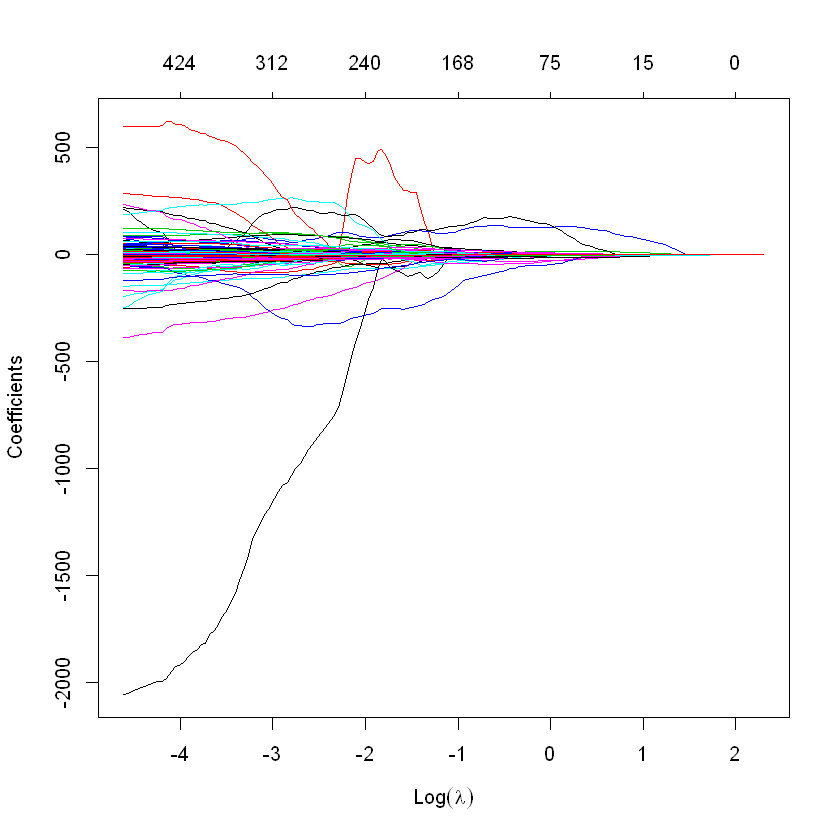

In [158]:
library(glmnet)

#split the training data in a training set and a validation set
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)
train.x <- as.matrix(x[idx.train,])
train.y <- as.matrix(y[idx.train])
val.x <- as.matrix(x[-idx.train,])
val.y <- as.matrix(y[-idx.train])

#Lasso model
lasso.mod <- glmnet(train.x,train.y, alpha = 1, lambda = 10^seq(1, -2, length = 150))
plot(lasso.mod, "lambda", xlab = parse(text = "Log(lambda)"))

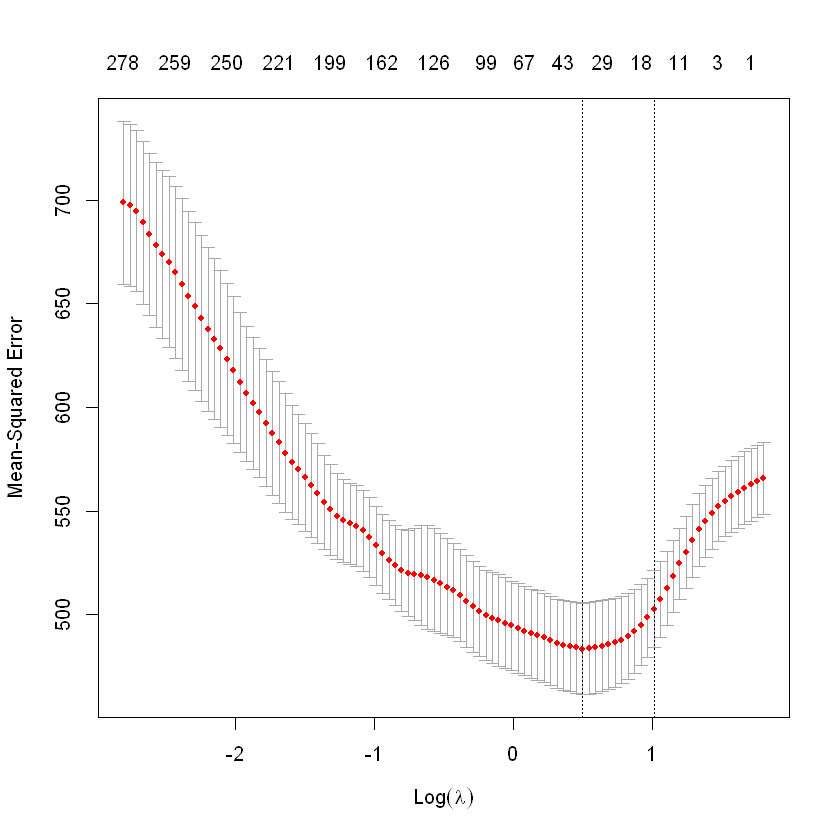

In [159]:
#5-fold cross-validation to find the optimal value for the parameter lambda
cv.lasso <- cv.glmnet(train.x, train.y, alpha = 1, nfold = 5)
plot(cv.lasso)

One can see that it is clearly better to not include all variables for a linear regression (as expected).  

In [162]:
#best prediction 
best.lasso <- glmnet(train.x, train.y, alpha = 1, lambda = cv.lasso$lambda.min)
pred <- predict(best.lasso, s = cv.lasso$lambda.min, newx = as.matrix(val.x))

#MSE with best lasso prediction 
mean((pred - val.y)^2)

[1] 465.7399

## Correlation

In [187]:
library(corrplot)
library(caret)
library(corrplot)
library(plyr)

#searching for variables with correlation = 1
corrData = scale(x, center=TRUE, scale = TRUE)  # normalize the data frame. This will also convert to a matrix. 
corrMatrix <- cor(x) # Access the correlation matrix (Pearson's coefficients)

highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 1)  # removes all indices of features which have a correltion of 0.99 or above
length(highlyCorrelated)

[1] 0

There are zero variables which have a correlation index of 1. Hence no variables are completly correlated to each other. We can try to reduce the predictors with 0.95 correlation (or higher) and see if the linear Regression with Lasso Regularization and K-Fold Cross Validation gives us a smaller validation MSE.

In [237]:
#searching for variables with correlation = 0.95
corrData = scale(x, center=TRUE, scale = TRUE)  # normalize the data frame. This will also convert to a matrix. 
corrMatrix <- cor(x) # Access the correlation matrix (Pearson's coefficients)
highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 0.95)  # removes all indices of features which have a correlation of 0.95 or above
highlyCorrCol <- colnames(x)[highlyCorrelated]
corr.x <- x[, -which(colnames(x) %in% highlyCorrCol)]  #Data frame with only uncorrelated data

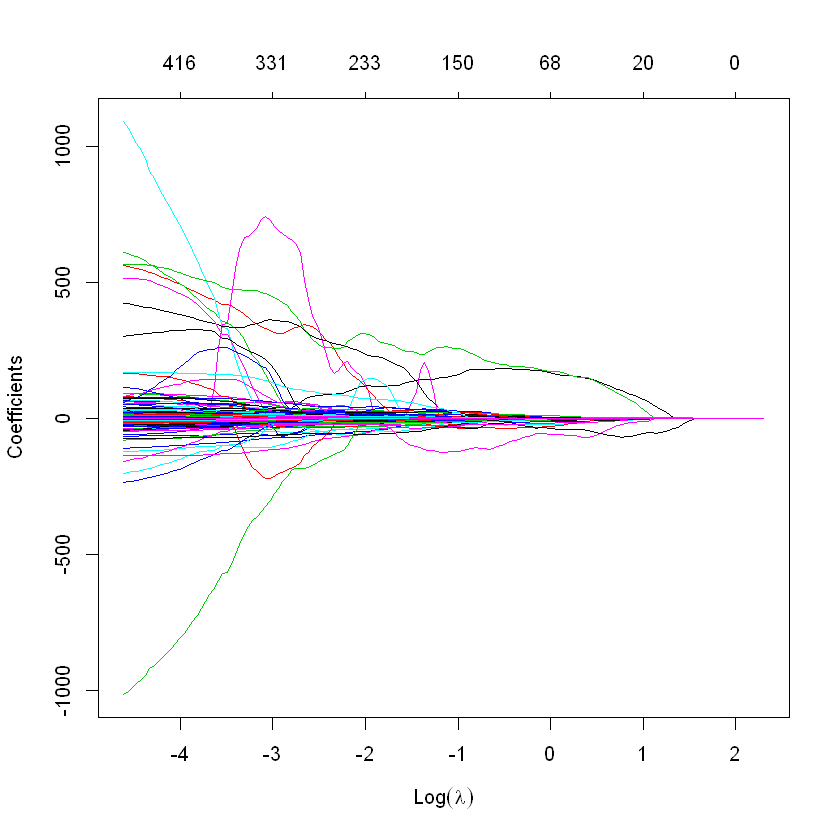

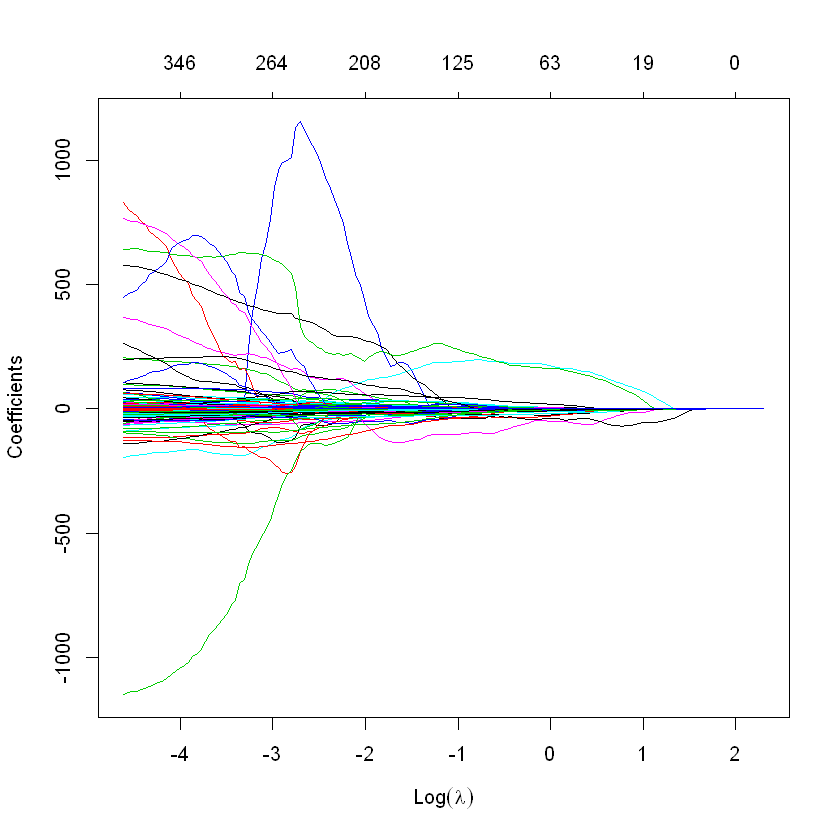

In [238]:
#split the training data in a training set and a validation set (one time with all predictors (var != 0), one time without to high correlated predictors

len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

train.x <- as.matrix(x[idx.train,])
train.y <- as.matrix(y[idx.train])
val.x <- as.matrix(x[-idx.train,])
val.y <- as.matrix(y[-idx.train])

corr.train.x <- as.matrix(corr.x[idx.train,])
corr.train.y <- as.matrix(y[idx.train])
corr.val.x <- as.matrix(corr.x[-idx.train,])
corr.val.y <- as.matrix(y[-idx.train])

#Lasso model
lasso.mod <- glmnet(train.x,train.y, alpha = 1, lambda = 10^seq(1, -2, length = 150))
plot(lasso.mod, "lambda", xlab = parse(text = "Log(lambda)"))

corr.lasso.mod <- glmnet(corr.train.x,corr.train.y, alpha = 1, lambda = 10^seq(1, -2, length = 150))
plot(corr.lasso.mod, "lambda", xlab = parse(text = "Log(lambda)"))

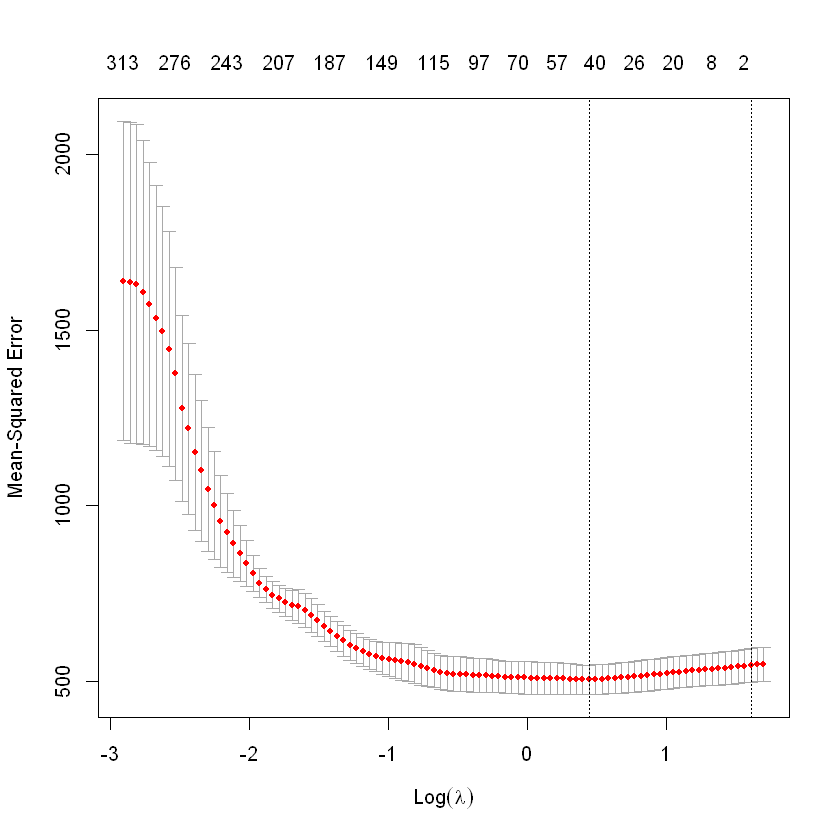

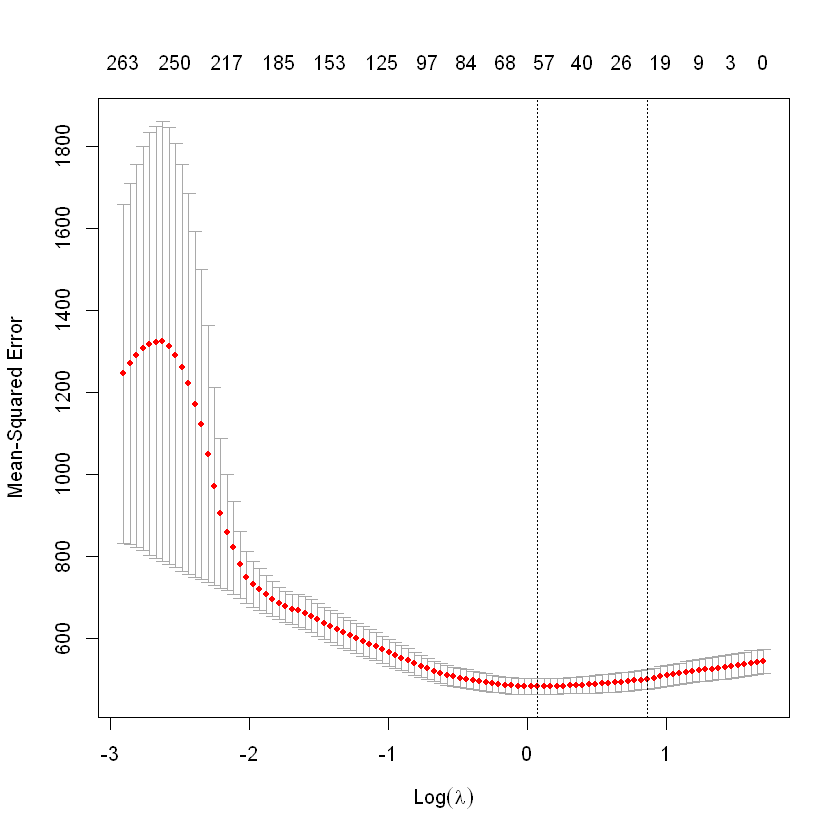

In [239]:
#5-fold cross-validation to find the optimal value for the parameter lambda
cv.lasso <- cv.glmnet(train.x, train.y, alpha = 1, nfold = 5)
plot(cv.lasso)

corr.cv.lasso <- cv.glmnet(corr.train.x, corr.train.y, alpha = 1, nfold = 5)
plot(corr.cv.lasso)

In [240]:
#best prediction 
best.lasso <- glmnet(train.x, train.y, alpha = 1, lambda = cv.lasso$lambda.min)
pred <- predict(best.lasso, s = cv.lasso$lambda.min, newx = as.matrix(val.x))

corr.best.lasso <- glmnet(corr.train.x, corr.train.y, alpha = 1, lambda = corr.cv.lasso$lambda.min)
corr.pred <- predict(corr.best.lasso, s = corr.cv.lasso$lambda.min, newx = as.matrix(corr.val.x))

#MSE with best lasso prediction 
mean((pred - val.y)^2)
mean((corr.pred - corr.val.y)^2)

[1] 485.1952

[1] 479.8681

Since the MSE does not diminish significantly we conserve all 3028 predictors for the further analyse.

Additionally, we can see that the MSE is around 450-520. 

## Forward Selection with Cross-Validation

In [255]:
library(tidymodels)
library(leaps)

#functions 
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}


evaluate <- function(fold, fit, formula = VALENCE.PLEASANTNESS ~ .) {
    valid.set <- assessment(fold)
    sapply(seq(1, fit$nvmax - 1),
           function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict(fit, valid.set, id, formula))^2))
}

fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ .) {
    fit <- regsubsets(formula, analysis(fold), method = "forward", nvmax = 60)
    evaluate(fold, fit)
}

#data
full.data <- x
full.data$VALENCE.PLEASANTNESS <- y
validation.data <- vfold_cv(full.data, v = 5)           
           
cv.errors <- sapply(validation.data$splits, fit_and_evaluate)
mean.cv.errors <- rowMeans(cv.errors)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2710  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2714  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2708  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2710  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2708  linear dependencies found"


Reordering variables and trying again:


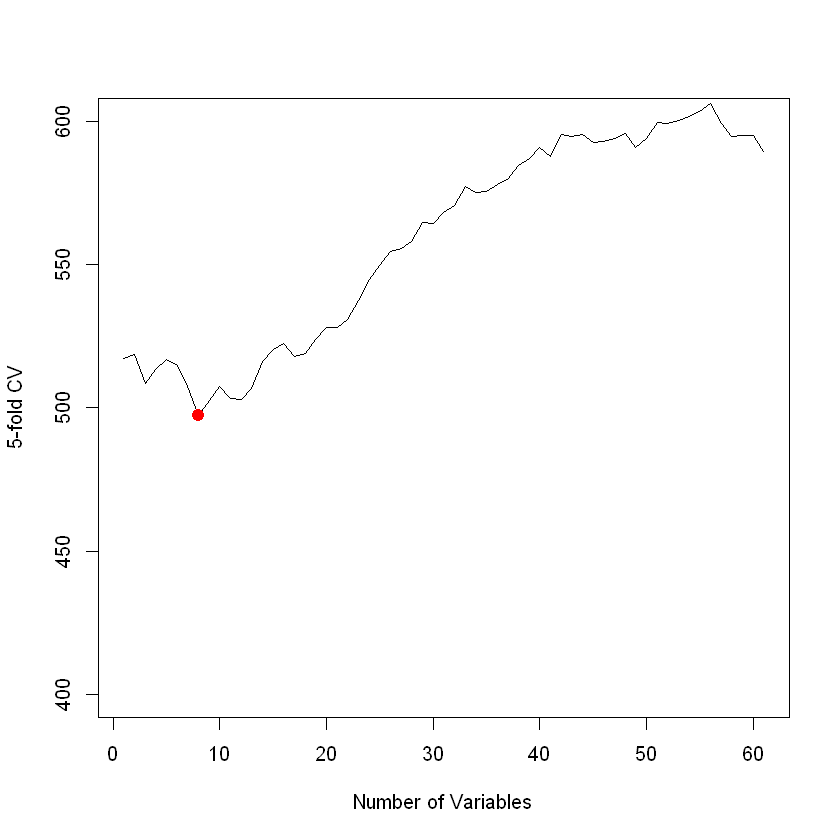

In [256]:
#plot the obtained data
plot(mean.cv.errors, type = "l", ylim = c(400, 600), xlab = "Number of Variables", ylab = "5-fold CV")
cv.min <- which.min(mean.cv.errors)
points(cv.min, mean.cv.errors[cv.min], col = "red", cex = 2, pch = 20)
abline(sd(full.data$VALENCE.PLEASANTNESS), 0, lty = "dashed")

We can see that the best predictions are obtained with a small number of variables. 